# Generare le istanze

Prima assicurati di avere tutti i pachetti necessari installati. Se non hai installato i pacchetti, esegui il comando seguente: 
```bash
pip3 install -r requirements.txt
```

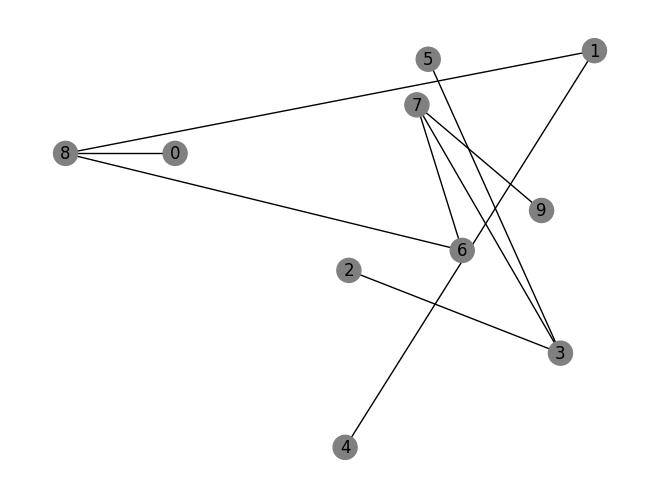

Number of edges:  9
Weight of the edges of the tree:  {(0, 8): 29.0, (1, 4): 153.87332452377834, (1, 8): 144.55448799674122, (2, 3): 63.06346010171025, (3, 5): 108.78419002777932, (3, 7): 94.93682109698007, (6, 8): 110.3675676999362, (6, 7): 52.392747589718944, (7, 9): 49.57822102496216}
Number of nodes:  10
Number of flows:  3


In [2]:
import networkx as nx
import utility_functions as uf

# CREATING A TREE NETWORK AND SAVING IT TO A .gml FILE

T = uf.generate_random_network_tree(10, 3, 150)
uf.draw_tree(T)

nx.write_gml(T, "tree_net/tree.gml")

print("Number of edges: ", T.number_of_edges())
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Number of nodes: ", T.number_of_nodes())
print("Number of flows: ", T.graph['K'])


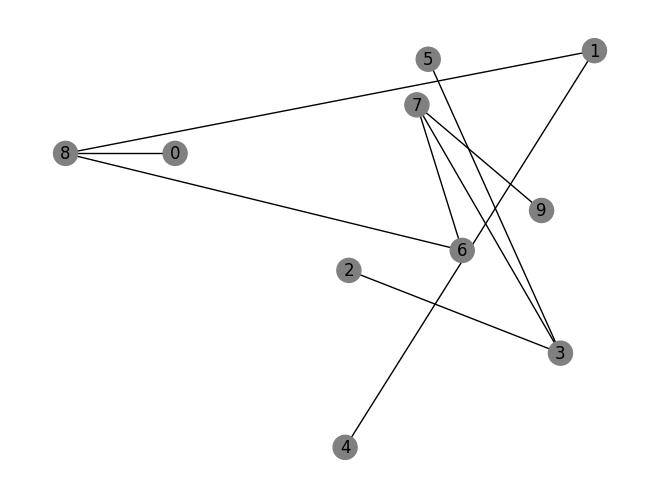

In [3]:
# READING THE TREE NETWORK FROM THE .gml FILE 

T = nx.read_gml("tree_net/tree.gml")
uf.draw_tree(T)